#Setup

In [34]:
!nvidia-smi

Sat Apr 23 15:42:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |    130MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip -qq install catboost

     |████████████████████████████████| 76.6 MB 1.3 MB/s 


# IMPORTS

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import torch
import os
import numpy as np

SEED_VAL  = 1000
# Set the seed value all over the place to make this reproducible.
def seed_all(SEED):
  random.seed(SEED_VAL)
  np.random.seed(SEED_VAL)
  torch.manual_seed(SEED_VAL)
  torch.cuda.manual_seed_all(SEED_VAL)
  os.environ['PYTHONHASHSEED'] = str(SEED_VAL)
  torch.backends.cudnn.deterministic = True
seed_all(SEED_VAL)


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from joblib import Parallel, delayed
from functools import reduce
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

# Loading the Data



In [5]:
train = pd.read_csv('/content/drive/MyDrive/GeoAI/Train.csv')
print(train.shape)
train.head()

(1004, 1202)


,ID,Target,timestep1_B02_mean,timestep1_B03_mean,timestep1_B04_mean,timestep1_B05_mean,timestep1_B06_mean,timestep1_B07_mean,timestep1_B08_mean,timestep1_B8A_mean,...,timestep24_B02_min,timestep24_B03_min,timestep24_B04_min,timestep24_B05_min,timestep24_B06_min,timestep24_B07_min,timestep24_B08_min,timestep24_B8A_min,timestep24_B11_min,timestep24_B12_min
0,6fba03cb,olive+cereals,456.918182,799.361364,825.761364,1420.606818,2478.922727,2882.245455,3084.704545,1989.954545,...,113.0,562.0,206.0,1193.0,1497.0,1588.0,1644.0,2060.0,1157.0,1630.0
1,7ea60a74,plowing_and_sowing,1087.130208,1653.770833,2194.458333,2447.984375,2588.328125,2725.609375,2777.385417,3698.088542,...,328.0,913.0,746.0,1468.0,1523.0,1603.0,1782.0,2308.0,1429.0,1741.0
2,64d18595,olive,917.369369,1383.882883,1742.765766,2012.234234,2388.657658,2592.783784,2644.738739,3111.837838,...,113.0,587.0,312.0,1161.0,2050.0,2182.0,2238.0,2016.0,1134.0,2372.0
3,119c8ec4,arable_soil,1013.775120,1551.863636,2073.009569,2371.222488,2666.064593,2843.196172,2930.330144,3802.370813,...,212.0,592.0,810.0,1289.0,1655.0,1796.0,1824.0,2418.0,1708.0,1965.0
4,d884d98c,olive,801.352113,1243.741784,1557.410798,1827.133803,2248.718310,2433.793427,2471.901408,2846.659624,...,84.0,326.0,480.0,790.0,1132.0,1207.0,1194.0,1595.0,1085.0,1283.0


In [6]:
test = pd.read_csv('/content/drive/MyDrive/GeoAI/Test.csv')
print(test.shape)
test.head()

(502, 1201)


,ID,timestep1_B02_mean,timestep1_B03_mean,timestep1_B04_mean,timestep1_B05_mean,timestep1_B06_mean,timestep1_B07_mean,timestep1_B08_mean,timestep1_B8A_mean,timestep1_B11_mean,...,timestep24_B02_min,timestep24_B03_min,timestep24_B04_min,timestep24_B05_min,timestep24_B06_min,timestep24_B07_min,timestep24_B08_min,timestep24_B8A_min,timestep24_B11_min,timestep24_B12_min
0,d8da32b5,901.974359,1255.743590,1561.230769,1891.230769,2340.333333,2568.282051,2679.179487,3381.820513,2856.641026,...,345.0,631.0,763.0,1299.0,1803.0,1964.0,2050.0,2384.0,1901.0,2171.0
1,670ad0fb,927.181818,1423.636364,1778.636364,2161.477273,2745.909091,2969.204545,3063.000000,3632.977273,2942.500000,...,600.0,1048.0,1416.0,2014.0,2367.0,2574.0,2614.0,3160.0,2482.0,2795.0
2,fec40ac9,716.611940,1126.828358,1390.171642,1751.037313,2480.328358,2757.880597,2798.059701,2913.335821,2234.589552,...,228.0,525.0,723.0,1106.0,1514.0,1582.0,1742.0,2141.0,1453.0,1761.0
3,4f6d4495,565.611940,931.238806,999.813433,1558.462687,2627.276119,2965.738806,3134.194030,2584.865672,1740.194030,...,245.0,528.0,723.0,1140.0,1270.0,1420.0,1532.0,2270.0,1387.0,1613.0
4,e56d2db7,943.473430,1371.809179,1709.190821,1926.652174,2180.309179,2325.961353,2378.082126,2846.335749,2323.219807,...,415.0,840.0,1046.0,1417.0,1885.0,2017.0,2080.0,2375.0,1665.0,2157.0


In [7]:
ss = pd.read_csv('/content/drive/MyDrive/GeoAI/SampleSubmission.csv')
print(ss.shape)
ss.head()

(502, 14)


,ID,arable_soil,cereals,forage_crop,greenhouses,mixed_crops,ochards,olive,olive+arbo,olive+cereals,olive+crops,plowing_and_sowing,vegetable_and_flower,wheat
0,d8da32b5,0,0,0,0,0,0,0,0,1,0,0,0,0
1,670ad0fb,0,0,0,0,0,0,0,0,0,0,1,0,0
2,fec40ac9,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4f6d4495,1,0,0,0,0,0,0,0,0,0,0,0,0
4,e56d2db7,0,0,0,0,0,0,0,1,0,0,0,0,0


# Data Processing

---



In [8]:
def process(train,test,ss) :
  
  target_mapper = dict(zip(ss.drop('ID',1).columns.tolist(),
                          [i for i in range(len(ss.drop('ID',1).columns.tolist()))]))  # Used to Encode Train Target 
  train['Target'] = train['Target'].map(target_mapper)
  
  Inversetarget_mapper = dict(zip([i for i in range(len(ss.drop('ID',1).columns.tolist()))],
                                  ss.drop('ID',1).columns.tolist())) # Used to Create submission file 

  in_cols = train.filter(like='timestep').columns.tolist() # features used in Training, we will use only time step 1 in this tutorial

  return target_mapper , Inversetarget_mapper , in_cols , train , test , ss

In [9]:
train = pd.read_csv('/content/drive/MyDrive/GeoAI/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/GeoAI/Test.csv')
ss = pd.read_csv('/content/drive/MyDrive/GeoAI/SampleSubmission.csv')

target_mapper , Inversetarget_mapper , in_cols , train , test , ss  = process(train,test,ss)

## Combine train and test datasets for easy manipulation

In [12]:
# Combining training and test data for easy manipulation
train_df, test_df, target_season = train.copy(), test.copy(), train.Target.copy()
splitter = train_df.shape[0]
comb = pd.concat([train_df, test_df], join = 'inner')
comb.head()

,ID,timestep1_B02_mean,timestep1_B03_mean,timestep1_B04_mean,timestep1_B05_mean,timestep1_B06_mean,timestep1_B07_mean,timestep1_B08_mean,timestep1_B8A_mean,timestep1_B11_mean,...,timestep24_B02_min,timestep24_B03_min,timestep24_B04_min,timestep24_B05_min,timestep24_B06_min,timestep24_B07_min,timestep24_B08_min,timestep24_B8A_min,timestep24_B11_min,timestep24_B12_min
0,6fba03cb,456.918182,799.361364,825.761364,1420.606818,2478.922727,2882.245455,3084.704545,1989.954545,1250.377273,...,113.0,562.0,206.0,1193.0,1497.0,1588.0,1644.0,2060.0,1157.0,1630.0
1,7ea60a74,1087.130208,1653.770833,2194.458333,2447.984375,2588.328125,2725.609375,2777.385417,3698.088542,2962.229167,...,328.0,913.0,746.0,1468.0,1523.0,1603.0,1782.0,2308.0,1429.0,1741.0
2,64d18595,917.369369,1383.882883,1742.765766,2012.234234,2388.657658,2592.783784,2644.738739,3111.837838,2456.693694,...,113.0,587.0,312.0,1161.0,2050.0,2182.0,2238.0,2016.0,1134.0,2372.0
3,119c8ec4,1013.775120,1551.863636,2073.009569,2371.222488,2666.064593,2843.196172,2930.330144,3802.370813,3152.626794,...,212.0,592.0,810.0,1289.0,1655.0,1796.0,1824.0,2418.0,1708.0,1965.0
4,d884d98c,801.352113,1243.741784,1557.410798,1827.133803,2248.718310,2433.793427,2471.901408,2846.659624,2175.328638,...,84.0,326.0,480.0,790.0,1132.0,1207.0,1194.0,1595.0,1085.0,1283.0


In [13]:
comb.shape

(1506, 1201)

In [14]:
comb.drop('ID',axis=1,inplace=True)

## Remove Skewness

In [15]:
# Remove skewness by using square root
comb = comb**(1/2.0)
comb.head()

,timestep1_B02_mean,timestep1_B03_mean,timestep1_B04_mean,timestep1_B05_mean,timestep1_B06_mean,timestep1_B07_mean,timestep1_B08_mean,timestep1_B8A_mean,timestep1_B11_mean,timestep1_B12_mean,...,timestep24_B02_min,timestep24_B03_min,timestep24_B04_min,timestep24_B05_min,timestep24_B06_min,timestep24_B07_min,timestep24_B08_min,timestep24_B8A_min,timestep24_B11_min,timestep24_B12_min
0,21.375645,28.272979,28.736064,37.690938,49.788781,53.686548,55.540117,44.608907,35.360674,56.231037,...,10.630146,23.706539,14.352700,34.539832,38.691084,39.849718,40.546270,45.387223,34.014703,40.373258
1,32.971658,40.666581,46.845046,49.477110,50.875614,52.207369,52.700905,60.811911,54.426365,52.929149,...,18.110770,30.215890,27.313001,38.314488,39.025633,40.037482,42.213742,48.041649,37.802116,41.725292
2,30.288106,37.200576,41.746446,44.857934,48.873895,50.919385,51.427023,55.783849,49.565045,52.013339,...,10.630146,24.228083,17.663522,34.073450,45.276926,46.711883,47.307505,44.899889,33.674916,48.703183
3,31.839835,39.393700,45.530315,48.695200,51.633948,53.321629,54.132524,61.663367,56.148257,54.375775,...,14.560220,24.331050,28.460499,35.902646,40.681691,42.379240,42.708313,49.173163,41.327957,44.328321
4,28.308163,35.266723,39.464044,42.744986,47.420653,49.333492,49.718220,53.354097,46.640419,49.870442,...,9.165151,18.055470,21.908902,28.106939,33.645208,34.741906,34.554305,39.937451,32.939338,35.818989


## Vegetation Index Calculation

In [16]:
i=1

In [17]:
comb.filter(like = "timestep"+str(i)+"_B02_mean").values

array([[21.37564459],
       [32.97165765],
       [30.28810607],
       ...,
       [32.91547617],
       [29.76780058],
       [28.71351317]])

In [18]:
# Calculation of vegetation indices
def vegetation_index(i):
  b02 = comb.filter(like = "timestep"+str(i)+"_B02_mean").values
  b03 = comb.filter(like = "timestep"+str(i)+"_B03_mean").values
  b04 = comb.filter(like = "timestep"+str(i)+"_B04_mean").values
  b05 = comb.filter(like = "timestep"+str(i)+"_B05_mean").values
  b06 = comb.filter(like = "timestep"+str(i)+"_B06_mean").values
  b07 = comb.filter(like = "timestep"+str(i)+"_B07_mean").values
  b08 = comb.filter(like = "timestep"+str(i)+"_B08_mean").values
  b8a = comb.filter(like = "timestep"+str(i)+"_B8A_mean").values
  b09 = comb.filter(like = "timestep"+str(i)+"_B09_mean").values   
  b11 = comb.filter(like = "timestep"+str(i)+"_B11_mean").values
  b12 = comb.filter(like = "timestep"+str(i)+"_B12_mean").values

  # WHEAT
  MI = (b8a - b11) / (b8a + b11)
  ARVI =  (b08 - (2 * b04) + b02) / (b08 + (2 * b04) + b02)
  SIPI = (b08 - b02) / (b08 - b04)
  RENDVI = (b06 - b05) / (b06 + b05) 

  RYI = b03 / b02
  NDYI = (b03 - b02) / (b03 + b02)
  DYI = b03 - b02
  ACI = b08 * (b04 + b03)

  CVI = (b08 / b03) * (b04 / b03)
  AVI = (b08 * (1 - b04) * (b08 - b04))
  SI = ((1 - b02) * (1 - b03) * (1 - b04))
  BSI = ((b11 + b04) - (b08 + b02)) / ((b11 + b04) + (b08 + b02))

  # SOIL
  SAVI = ((b08 - b04)/(b08 + b04 + 0.33)) * (1 + 0.33)

  FIDET = b12 / (b8a * b09)
  MTCI = (b06 - b05)/(b05 - b04)
  NPCRI = (b04 - b02) / (b04 + b02)

  # GREENNESS
  S2REP = 705 + 35 * ((((b07 + b04)/2) - b05)/(b06 - b05)) 
  CCCI = ((b08 - b05) / (b08 + b05)) / ((b08 - b04) / (b08 + b04)) 
  MCARI = ((b05 - b04) - 2 * (b05 - b03)) * (b05 / b04)  
  TCARI = 3 * ((b05 - b04) - 0.2 * (b05 - b03) * (b05 / b04)) 
  PVI = (b08 - 0.3 * b04 - 0.5) / ((1 + 0.3 * 2) ** (1/2.0)) 
  EVI = 2.5*(b08 - b04) / (b08 + 6*b04 - 7.5*b02 + 1) 
  NDVI = ((b08 - b04)/(b08 + b04))

  # ROOIBOS
  BAI = 1/((0.1 - b04) ** 2 + (0.06 - b08) ** 2)
  MTVI2 = list(1.5*(1.2 * (i - j) - 2.5 * (k - j))* ((2 * i + 1)**2-(6 * i - 5 * k ** (1/2.0)) - 0.5)**(1/2.0) for i, j, k in zip(b08, b03, b04))
  NDSI = (b03 - b11) / (b03 + b11)

  # RED EDGE
  NDVIre = (b08 - b05)/(b08 + b05)
  CIre = ((b08 / b05) - 1)

  # DRYNESS / DROUGHT
  NDMI = (b08 - b11)/(b08 + b11) 
  TNDVI = [(x)**(1/2.0) for x in ((b08 - b04) / (b08 + b04) + 0.5)]

  # BASED ON THE VISIBLE SPECTRA REGION
  VDVI = (2 * b03 - b04 - b02) / (2 * b03 + b04  + b02) 

  # BURN
  NBR = (b08 - b11) / (b08+ b11) 

  # GENERAL
  TVI = (120 * (b06 - b03) - 200 * (b04 - b03)) / 2
  EXG = 2 * b03 - b04 - b02
  PSRI = (b04 - b02) / b06
  RDVI = [(i - j) / (i + j)**(1/2.0) for i, j in zip(b08, b04)]

  # COMMON BAND RATIOS
  RATIO3 = b11 / b12
  RATIO4 = b05 / b04

  return [MI, ARVI, SIPI, RENDVI, RYI, NDYI, DYI, ACI, CVI, AVI, SI, BSI, SAVI, FIDET, MTCI, NPCRI, S2REP, CCCI,\
          MCARI, TCARI, PVI, EVI, NDVI, BAI, MTVI2, NDSI,  NDVIre, CIre, NDMI, TNDVI, VDVI, NBR, TVI, EXG, PSRI, RDVI, \
          RATIO3, RATIO4]


In [19]:
spectral_indices = ['MI', 'ARVI', 'SIPI', 'RENDVI', 'RYI', 'NDYI', 'DYI', 'ACI', 'CVI', 'AVI', 'SI', 'BSI',
                    'SAVI', 'FIDET', 'MTCI', 'NPCRI', 'S2REP', 'CCCI', 'MCARI', 'TCARI', 'PVI', 'EVI', 'NDVI', 'BAI', 'MTVI2', 'NDSI',
                    'NDVIre', 'CIre', 'NDMI', 'TNDVI', 'VDVI', 'NBR', 'TVI', 'EXG', 'PSRI', 'RDVI', 'RATIO3', 'RATIO4']

# Parallel processing to speed up the calculation of the vegetation indices
vegs = Parallel(n_jobs=-1, verbose=2, backend="multiprocessing")(map(delayed(vegetation_index), [x for x in range(1,25)]))

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    3.5s finished


In [20]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [21]:
# Adding the calculated indices to the combined dataframe
vi_df = pd.DataFrame()
for i in tqdm_notebook(range(24)):
  for n, m in zip(spectral_indices, vegs[i]):
    
    try:
      vi_df['timestep'+str(i+1)+'_' + n] = m.tolist()
    except:
      vi_df['timestep'+str(i+1)+'_' + n] = m

# Previewing the head of the engineered dataframe
vi_df.head()   

  0%|          | 0/24 [00:00<?, ?it/s]

,timestep1_MI,timestep1_ARVI,timestep1_SIPI,timestep1_RENDVI,timestep1_RYI,timestep1_NDYI,timestep1_DYI,timestep1_ACI,timestep1_CVI,timestep1_AVI,...,timestep24_NDMI,timestep24_TNDVI,timestep24_VDVI,timestep24_NBR,timestep24_TVI,timestep24_EXG,timestep24_PSRI,timestep24_RDVI,timestep24_RATIO3,timestep24_RATIO4
0,[0.11564687965840562],[0.1446829300030343],[1.2746009828109426],[0.13829311632172603],[1.3226725990063728],[0.13892297999486045],[6.897334796651794],[3166.288903633663],[1.9965992927482894],[-41290.68408755856],...,[0.08025110020409339],[0.7984893108368132],[0.03860989705605132],[0.08025110020409339],[381.3338793650895],[4.9575148049715665],[0.28227225027377606],[1.2817475523811896],[0.852337645501516],[1.1066809445556964]
1,[0.05541168079029316],[-0.04470010241931467],[3.3691464648877343],[0.01393589119303396],[1.233379944467552],[0.10449630169092915],[7.694923631871639],[4611.941979051628],[1.49281646600288],[-14148.19772398109],...,[0.1219905610410414],[0.8301113290046476],[0.05123148315966837],[0.1219905610410414],[734.6923702805841],[6.542036316022063],[0.24775837035227494],[1.796190843654449],[0.7888795085776982],[1.149317132316034]
2,[0.05903055951680727],[-0.01076075345293324],[2.183642229062579],[0.042845227542059425],[1.228223920344856],[0.10242414070733716],[6.912470307349057],[4060.0103769549546],[1.551356325406719],[-20285.34418367693],...,[0.22017326229312614],[0.9322281076855984],[0.12033466458135778],[0.22017326229312614],[1758.1186239261528],[12.855106542931463],[0.16123797950437735],[3.477496122323143],[0.6492579299028537],[1.3922846664307778]
3,[0.046812949396449074],[-0.028741933292974968],[2.591507405356177],[0.029291071290216845],[1.2372457314859624],[0.10604366259239013],[7.55386504477649],[4597.151287986079],[1.588200662973909],[-20735.954676845664],...,[0.03842993275527438],[0.790905669342873],[0.02442367764187716],[0.03842993275527438],[331.0010106057456],[3.597019376928273],[0.27438360258656336],[1.2459944286525086],[0.9326449514559865],[1.1063949216083095]
4,[0.06714046354971304],[-0.00574501182903807],[2.087935424987086],[0.051856418394168866],[1.245814609049029],[0.10945454182129355],[6.958560108624905],[3715.4807624745868],[1.5775638228762603],[-19609.71467480297],...,[0.06909918925603283],[0.8184354556443982],[0.03758934278642174],[0.06909918925603283],[365.1861658141458],[3.8850916655306627],[0.30652022019390945],[1.4670822826705319],[0.8661478875104182],[1.10517091700286]


In [22]:
for col in vi_df.columns:
  print(col)
  if flatten(vi_df[col].values)==[]:
    vi_df.drop(col,axis=1,inplace=True)
  else:
    vi_df[col]=flatten(vi_df[col].values)

timestep1_MI
timestep1_ARVI
timestep1_SIPI
timestep1_RENDVI
timestep1_RYI
timestep1_NDYI
timestep1_DYI
timestep1_ACI
timestep1_CVI
timestep1_AVI
timestep1_SI
timestep1_BSI
timestep1_SAVI
timestep1_FIDET
timestep1_MTCI
timestep1_NPCRI
timestep1_S2REP
timestep1_CCCI
timestep1_MCARI
timestep1_TCARI
timestep1_PVI
timestep1_EVI
timestep1_NDVI
timestep1_BAI
timestep1_MTVI2
timestep1_NDSI
timestep1_NDVIre
timestep1_CIre
timestep1_NDMI
timestep1_TNDVI
timestep1_VDVI
timestep1_NBR
timestep1_TVI
timestep1_EXG
timestep1_PSRI
timestep1_RDVI
timestep1_RATIO3
timestep1_RATIO4
timestep2_MI
timestep2_ARVI
timestep2_SIPI
timestep2_RENDVI
timestep2_RYI
timestep2_NDYI
timestep2_DYI
timestep2_ACI
timestep2_CVI
timestep2_AVI
timestep2_SI
timestep2_BSI
timestep2_SAVI
timestep2_FIDET
timestep2_MTCI
timestep2_NPCRI
timestep2_S2REP
timestep2_CCCI
timestep2_MCARI
timestep2_TCARI
timestep2_PVI
timestep2_EVI
timestep2_NDVI
timestep2_BAI
timestep2_MTVI2
timestep2_NDSI
timestep2_NDVIre
timestep2_CIre
timestep2_NDMI

In [24]:
# Calculate mean indices
def aggregator(ix):
  df = pd.Series(vi_df[[x for x in vi_df.columns if x.split('_')[-1] == ix]].mean(axis = 1)).to_frame()
  df.columns = [ix + '_' + 'MEAN']
  return df

for ix in tqdm_notebook(spectral_indices):
  vi_df = vi_df.merge(aggregator(ix), how = 'left', left_index=True, right_index=True)

vi_df.head()

  0%|          | 0/38 [00:00<?, ?it/s]

,timestep1_MI,timestep1_ARVI,timestep1_SIPI,timestep1_RENDVI,timestep1_RYI,timestep1_NDYI,timestep1_DYI,timestep1_ACI,timestep1_CVI,timestep1_AVI,...,NDMI_MEAN,TNDVI_MEAN,VDVI_MEAN,NBR_MEAN,TVI_MEAN,EXG_MEAN,PSRI_MEAN,RDVI_MEAN,RATIO3_MEAN,RATIO4_MEAN
0,0.115647,0.144683,1.274601,0.138293,1.322673,0.138923,6.897335,3166.288904,1.996599,-41290.684088,...,0.215147,0.907092,0.094012,0.215147,1419.978645,9.468883,0.168792,3.076357,0.661048,1.348115
1,0.055412,-0.044700,3.369146,0.013936,1.233380,0.104496,7.694924,4611.941979,1.492816,-14148.197724,...,0.153022,0.855469,0.053684,0.153022,947.138508,6.475339,0.216110,2.249160,0.743297,1.201784
2,0.059031,-0.010761,2.183642,0.042845,1.228224,0.102424,6.912470,4060.010377,1.551356,-20285.344184,...,0.209879,0.925386,0.101980,0.209879,1660.081522,10.875615,0.148364,3.418101,0.663939,1.390643
3,0.046813,-0.028742,2.591507,0.029291,1.237246,0.106044,7.553865,4597.151288,1.588201,-20735.954677,...,0.016552,0.785919,0.019564,0.016552,279.010554,2.879984,0.272457,1.166552,0.969563,1.102133
4,0.067140,-0.005745,2.087935,0.051856,1.245815,0.109455,6.958560,3715.480762,1.577564,-19609.714675,...,0.060649,0.804452,0.026588,0.060649,361.535509,3.285495,0.262471,1.354191,0.885042,1.108258


## Fill missing values 

In [25]:
# Fill missing values with -999999
vi_df = vi_df.fillna(-999999).replace([np.inf, -np.inf], -999999)

In [26]:
# Check shape of all data
vi_df.shape

(1506, 926)

In [27]:
s_train = vi_df[:splitter]
s_test = vi_df[splitter:]
s_train.head()

,timestep1_MI,timestep1_ARVI,timestep1_SIPI,timestep1_RENDVI,timestep1_RYI,timestep1_NDYI,timestep1_DYI,timestep1_ACI,timestep1_CVI,timestep1_AVI,...,NDMI_MEAN,TNDVI_MEAN,VDVI_MEAN,NBR_MEAN,TVI_MEAN,EXG_MEAN,PSRI_MEAN,RDVI_MEAN,RATIO3_MEAN,RATIO4_MEAN
0,0.115647,0.144683,1.274601,0.138293,1.322673,0.138923,6.897335,3166.288904,1.996599,-41290.684088,...,0.215147,0.907092,0.094012,0.215147,1419.978645,9.468883,0.168792,3.076357,0.661048,1.348115
1,0.055412,-0.044700,3.369146,0.013936,1.233380,0.104496,7.694924,4611.941979,1.492816,-14148.197724,...,0.153022,0.855469,0.053684,0.153022,947.138508,6.475339,0.216110,2.249160,0.743297,1.201784
2,0.059031,-0.010761,2.183642,0.042845,1.228224,0.102424,6.912470,4060.010377,1.551356,-20285.344184,...,0.209879,0.925386,0.101980,0.209879,1660.081522,10.875615,0.148364,3.418101,0.663939,1.390643
3,0.046813,-0.028742,2.591507,0.029291,1.237246,0.106044,7.553865,4597.151288,1.588201,-20735.954677,...,0.016552,0.785919,0.019564,0.016552,279.010554,2.879984,0.272457,1.166552,0.969563,1.102133
4,0.067140,-0.005745,2.087935,0.051856,1.245815,0.109455,6.958560,3715.480762,1.577564,-19609.714675,...,0.060649,0.804452,0.026588,0.060649,361.535509,3.285495,0.262471,1.354191,0.885042,1.108258


# MODELING

---



In [28]:
# Select X and y features
X = s_train.copy()
y = target_season.copy()
tess = s_test.copy()


# Stratified Validation
folds = StratifiedKFold(n_splits = 10)

# Dataframe to store feature importance
feature_importance_df = pd.DataFrame()

# Lists to store predictions and losses
season_predictions = []
losses = []
for i,( train_index, test_index) in enumerate(folds.split(X, y)):
  X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]

  # Instantiate model
  model = CatBoostClassifier(n_estimators=25000,learning_rate=0.005, task_type='GPU',random_seed=SEED_VAL, bagging_temperature=1,
                             early_stopping_rounds=200, verbose = 1000, use_best_model = True)

  # Train model
  model.fit(X_train, y_train,
            eval_set=[(X_test, y_test)]
            )

  # Make predictions
  preds = model.predict_proba(tess)
  y_pred = model.predict_proba(X_test)

  # Append predictions and losses
  season_predictions.append(preds)
  loss = log_loss(y_test, y_pred)

  # Append feature importance per fold
  fold_importance_df = pd.DataFrame({'feature': X_train.columns.tolist(), 'importance': model.feature_importances_})
  feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

  # Print loss
  print(f'{i+1}:  {loss}\n')
  losses.append(loss)

print(f'Mean Loss: {np.mean(losses)}')

0:	learn: 2.5549611	test: 2.5557336	best: 2.5557336 (0)	total: 114ms	remaining: 47m 27s
1000:	learn: 1.0324637	test: 1.4875951	best: 1.4875951 (1000)	total: 51.6s	remaining: 20m 36s
2000:	learn: 0.7529606	test: 1.4204340	best: 1.4204340 (2000)	total: 1m 38s	remaining: 18m 55s
3000:	learn: 0.5829323	test: 1.4058898	best: 1.4056958 (2914)	total: 2m 23s	remaining: 17m 35s
bestTest = 1.403382254
bestIteration = 3239
Shrink model to first 3240 iterations.
1:  1.4033825950571184

0:	learn: 2.5548762	test: 2.5555535	best: 2.5555535 (0)	total: 53.2ms	remaining: 22m 10s
1000:	learn: 1.0472842	test: 1.3873687	best: 1.3873687 (1000)	total: 49.8s	remaining: 19m 53s
2000:	learn: 0.7744104	test: 1.2907452	best: 1.2907452 (2000)	total: 1m 36s	remaining: 18m 24s
3000:	learn: 0.6090137	test: 1.2531022	best: 1.2531022 (3000)	total: 2m 21s	remaining: 17m 15s
4000:	learn: 0.4889435	test: 1.2292903	best: 1.2292680 (3996)	total: 3m 6s	remaining: 16m 16s
5000:	learn: 0.3999130	test: 1.2157748	best: 1.2157748

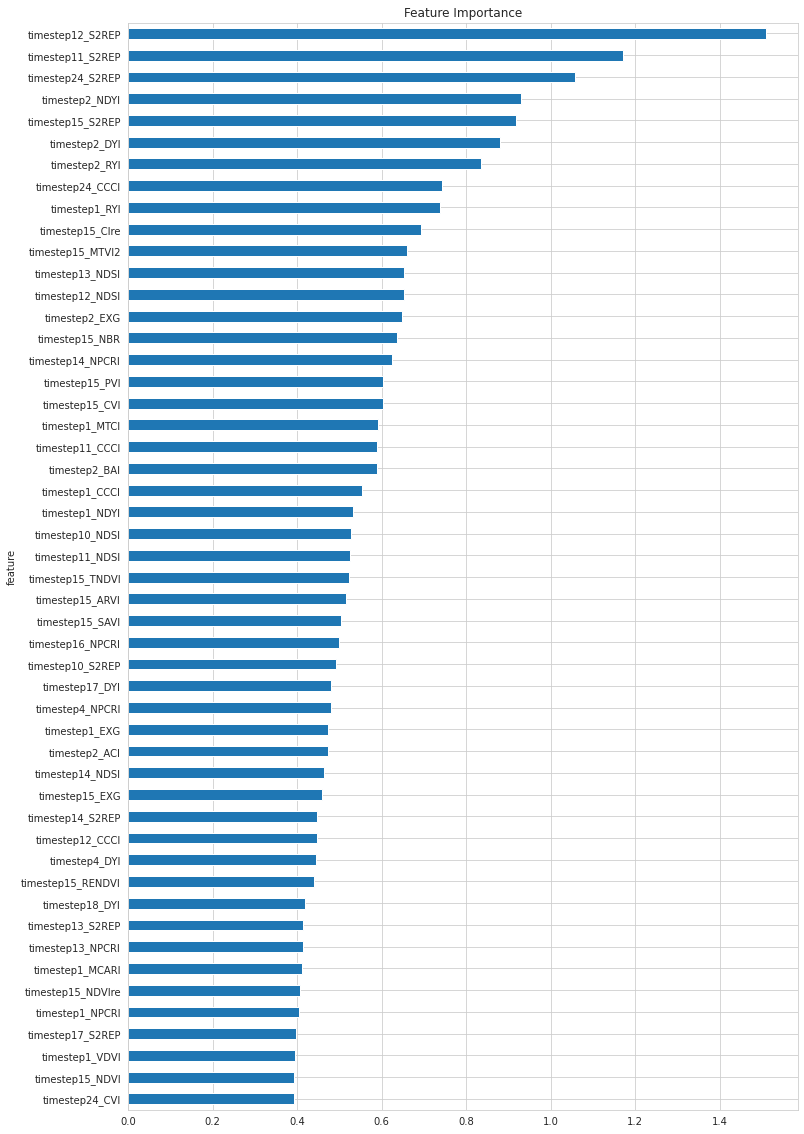

In [29]:
# Feature Importance plot
sns.set_style('whitegrid')
fi = feature_importance_df.groupby('feature')['importance'].mean()
fi.sort_values(ascending=False)[:50][::-1].plot(kind = 'barh', figsize=(12, 20), title = 'Feature Importance')
plt.show()

In [30]:
test_prediction = np.mean(season_predictions, 0)

In [31]:
test_prediction.shape

(502, 13)

# SUBMISSION

---



In [32]:
sub = pd.DataFrame(test_prediction)
sub = sub.rename(columns=Inversetarget_mapper)
sub['ID'] =  test['ID'].values
submission = pd.read_csv('/content/drive/MyDrive/GeoAI/SampleSubmission.csv')
submission = pd.merge(sub[['ID']],submission,on='ID',how='left')

for col in submission.columns[1:] :
  submission[col] = sub[col]
  
submission.head()

,ID,arable_soil,cereals,forage_crop,greenhouses,mixed_crops,ochards,olive,olive+arbo,olive+cereals,olive+crops,plowing_and_sowing,vegetable_and_flower,wheat
0,d8da32b5,0.067335,0.004290,0.024883,0.002724,0.026723,0.026673,0.728990,0.050105,0.030853,0.020872,0.003370,0.004580,0.008600
1,670ad0fb,0.064521,0.009160,0.021552,0.008996,0.050874,0.215642,0.227574,0.191876,0.089185,0.055398,0.024402,0.020868,0.019952
2,fec40ac9,0.009775,0.013092,0.008106,0.006722,0.049086,0.719948,0.038891,0.023387,0.011280,0.057237,0.016280,0.034266,0.011929
3,4f6d4495,0.008737,0.016449,0.016776,0.003828,0.097471,0.137448,0.297358,0.101725,0.155511,0.104160,0.005133,0.022401,0.033004
4,e56d2db7,0.185818,0.087124,0.096186,0.033352,0.041367,0.111804,0.090736,0.026797,0.122410,0.015390,0.102030,0.018173,0.068813


In [33]:
submission.to_csv('submission.csv',index=False)